In [109]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [110]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
def phase_plot(t_range, f_range, y, dbf = 60):
    eps = 1e-3
    
#     # find maximum
#     y_max = abs(y).max()
    
#     # compute 20*log magnitude, scaled to the max
#     y_log = 20.0 * np.log10( abs( y ) / y_max + eps )

    y_phase = np.angle(y)
    
    fig=figure(figsize=(15,6))
    # 64.0*(y_phase + dbf)/dbf 
    plt.imshow( np.flipud(y_phase ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def myspectrogram_phase_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        phase_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        phase_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [111]:
def iq_demod_tone(f0, n_samps, fc, fs):
    assert abs(f0 - fc) < fs/2
    t = np.r_[:n_samps]/fs
    return np.exp(1j*2*pi*(f0 - fc)*t)

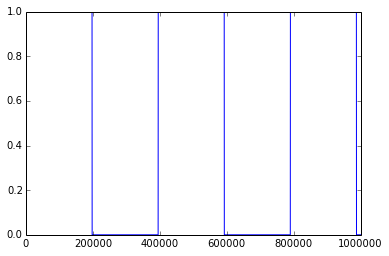

In [112]:
fc = 145.230e6
fs = 1e6
f0 = 145.530e6
sec = 1 #number of seconds
n_samples = sec * fs
#t = np.arange(n_samples) * (1/fs)
#sig = 3*sin(fc*t*2*pi)
sig = iq_demod_tone(f0, n_samples, fc, fs)*((signal.square(np.arange(n_samples)/(2*pi*10000))+1)/2)


figure()
plt.plot(abs(sig))


In [123]:
#generate received signals

# Positions of antennas and source
# The origin is at the midpoint between the two antennas

d = 0.5 # Distance between the antennas (in meters)
c = 3e8


pos_a0 = np.array([-d/2, 0])
pos_a1 = np.array([d/2, 0])
pos_src = np.array([d/2, d/2])

angle = np.arccos(np.dot(pos_src, pos_a1) / (np.linalg.norm(pos_src) * np.linalg.norm(pos_a1))) - np.pi/2

phase_diff_pos = d*np.cos(pi/2 - angle)*2*pi*f0/c

print phase_diff_pos

delay_amt = 1024
sigma_0 = 0.01
delay_bit0 = sigma_0 * np.random.randn( delay_amt ) + sigma_0*1j * np.random.randn( delay_amt ) 
phase_offset = 0.5

y0 = sig * np.exp(-1j*phase_offset)

#if np.linalg.norm(pos_a0 - pos_src) > np.linalg.norm(pos_a1 - pos_src):
#    y0 = y0 * np.exp(-1j*phase_diff_pos)
y0 = y0 * np.exp(-1j*phase_diff_pos)

clean_y0 = np.concatenate((np.zeros(delay_amt), y0[:-delay_amt]))

y0 +=  sigma_0 * np.random.randn( len(sig) ) + sigma_0*1j * np.random.randn( len(sig) )
y0 = np.concatenate((delay_bit0, y0[:-delay_amt]))

sigma_1 = 0.01
y1 = sig
#if np.linalg.norm(pos_a0 - pos_src) < np.linalg.norm(pos_a1 - pos_src):
#    y1 = y1 * np.exp(-1j*phase_diff_pos)

y1 += sigma_1 * np.random.randn( len(sig) ) + sigma_1 * 1j * np.random.randn( len(sig) )
clean_y1 = sig

print angle

-1.07762125665
-0.785398163397


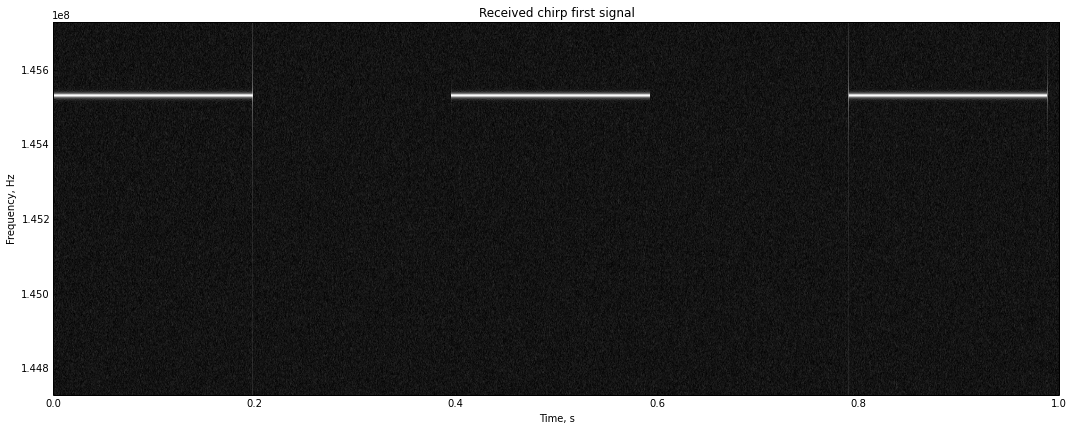

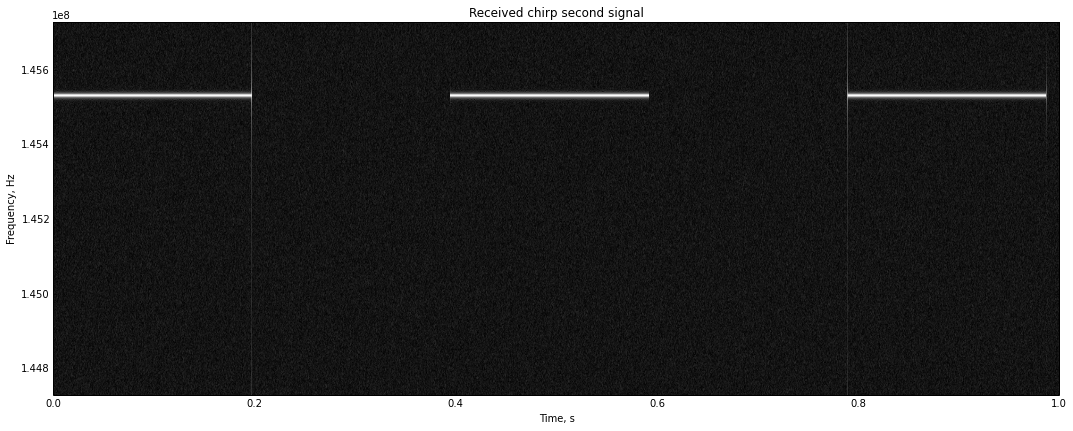

In [114]:
m = 512

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')

800547
800547
800547
800688


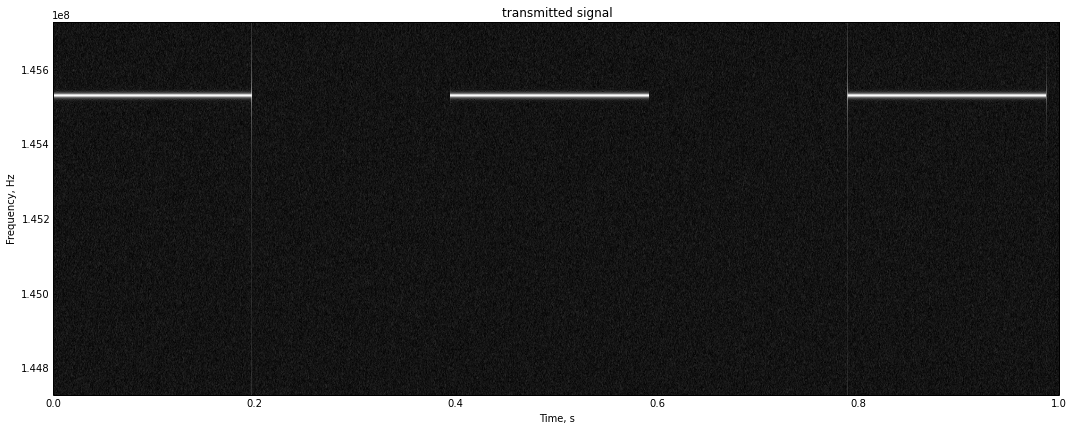

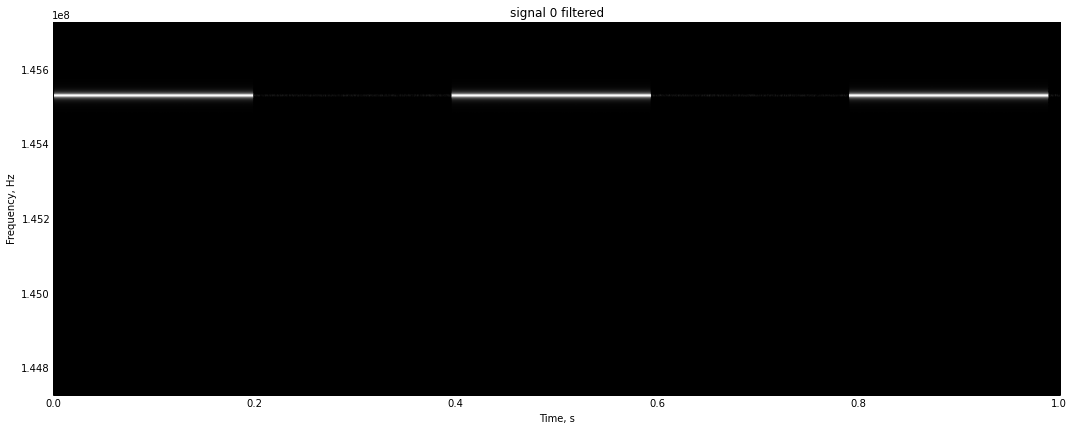

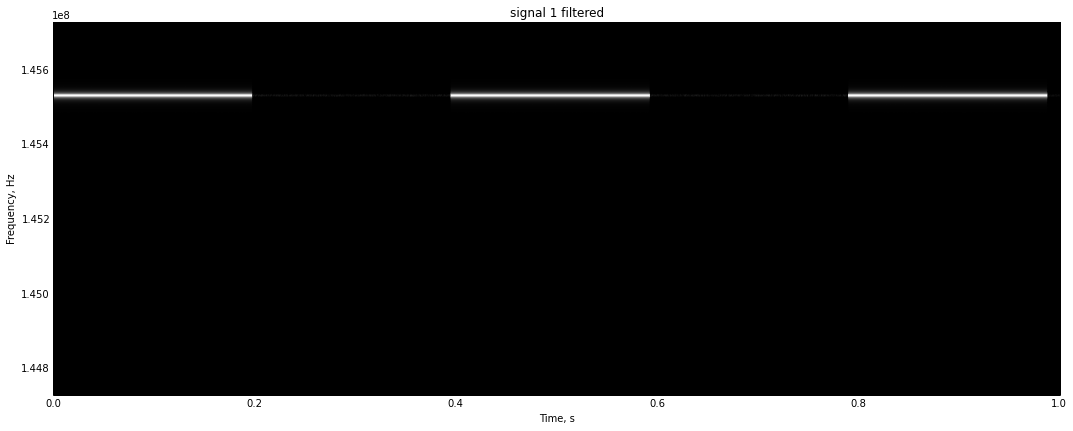

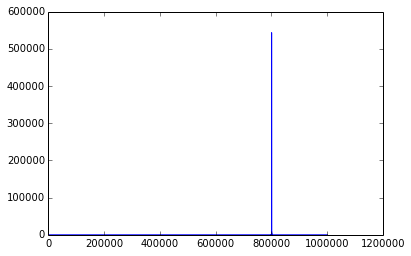

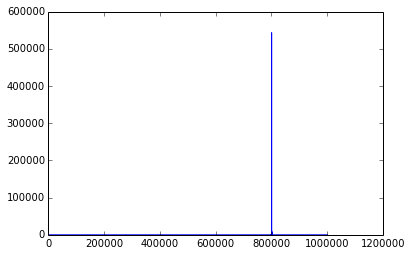

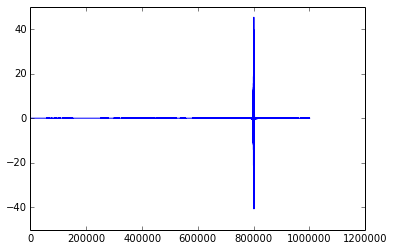

In [115]:
taps = 685 # Should be odd so we have Type I niceness
# taps = 700

mod_val = (f0 - fc)
h = sp.signal.firwin(taps, 1/fs)
t = np.arange(taps) * (1/fs)
mod = exp(1j*2*pi*mod_val*t)
h = h*mod

filt_sig = signal.fftconvolve(sig, h)
filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)
trunc_y0 = filt_y0[:-taps]#[int(taps/2) : -int(taps/2)] # assumes taps is odd! 
trunc_y1 = filt_y1[:-taps]#[int(taps/2) : -int(taps/2)] # assumes taps is odd!

myspectrogram_hann_ovlp(sig, m, fs, fc, dbf = 63)
title('transmitted signal')
myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('signal 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('signal 1 filtered')

freqsig = np.fft.fftshift(np.fft.fft(filt_sig)) 
freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print np.argmax(abs(freqsig))
print np.argmax(abs(freq0))
print np.argmax(abs(freq1))
print np.argmax(abs(freq0)-abs(freq1))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]


1024
1025
1024
1024
1025
1024
1025
TRU DELAY: 1024


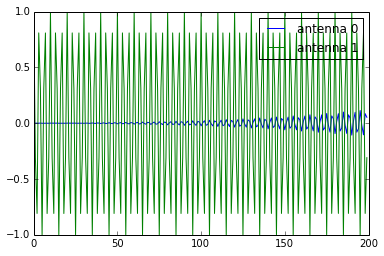

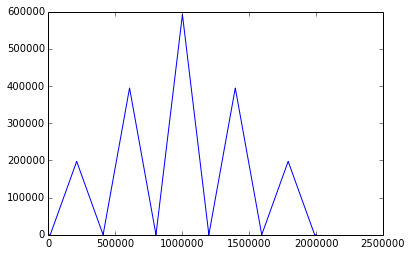

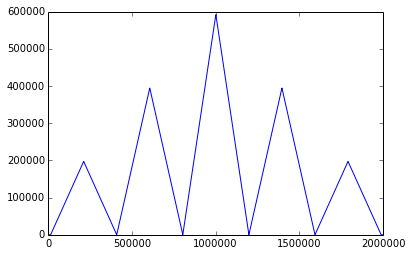

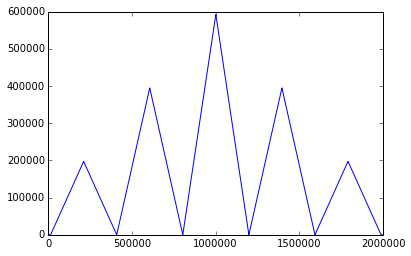

In [116]:
# Calculating USB delay

figure()
plt.plot(filt_y0[1000:1200], label='antenna 0')
plt.plot(filt_y1[1000:1200], label='antenna 1')
plt.legend()

# figure()
# plt.plot(filt_y0, label='antenna 0')
# plt.plot(filt_y1, label='antenna 1')
# plt.legend()
clean_xcorr_abs = abs(signal.fftconvolve(clean_y0, np.conjugate(clean_y1)[::-1]))

filt_xcorr_abs = abs(signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1]))
filt_xcorr = signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1])
filt_trun_xcorr_abs = abs(signal.fftconvolve(trunc_y0, np.conj(trunc_y1[::-1])))
filt_trun_xcorr = signal.fftconvolve(trunc_y0, np.conj(trunc_y1[::-1]))

figure()
plt.plot(filt_xcorr_abs)

figure()
plt.plot(filt_trun_xcorr_abs)

orig_xcorr = signal.fftconvolve(y0, np.conjugate(y1)[::-1])
orig_xcorr_abs = abs(signal.fftconvolve(y0, np.conjugate(y1)[::-1]))

figure()
#plt.plot(orig_xcorr)
plt.plot(orig_xcorr_abs)
print np.argmax(clean_xcorr_abs) - clean_y0.size + 1
print np.argmax(filt_xcorr)-filt_y0.size + 1
print np.argmax(filt_xcorr_abs)-filt_y0.size + 1
print np.argmax(filt_trun_xcorr_abs)-trunc_y0.size + 1
print np.argmax(filt_trun_xcorr)-trunc_y0.size + 1
print np.argmax(orig_xcorr_abs)-y0.size + 1
print np.argmax(orig_xcorr)-y0.size + 1

delay = np.argmax(filt_trun_xcorr_abs) - trunc_y0.size + 1
print "TRU DELAY: %d" % delay

-2.0239877195
-1.024067758


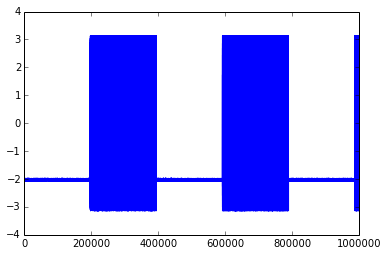

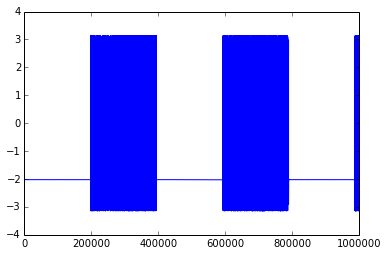

In [117]:
# 1031 1044
phase_diff = np.angle(y0[delay:] * np.conjugate(y1[:-delay]))
# phase_diff = np.angle(y0[:delay] * np.conjugate(y1[-delay:]))
figure()
plt.plot(phase_diff)

print np.mean(phase_diff[:100000])

phase_diff = np.angle(trunc_y0[delay:] * np.conjugate(trunc_y1[:-delay]))
figure()
plt.plot(phase_diff)

print np.mean(phase_diff[:800000])


In [118]:
def find_tone(sig, f0, fc, fs, threshold=0.5, burst_len=512):
    t = np.r_[:burst_len]/fs
    tone_burst = np.exp(2j*pi*(f0-fc)*t)

    match = np.abs(signal.fftconvolve(sig, np.conj(tone_burst[::-1]))[int(tone_burst.size/2) - 1: -int(tone_burst.size/2)])
    match /= np.max(match)
    
    assert match.size == sig.size

    matched = match > 0.35
    plt.plot(matched)
    plt.ylim(-0.1,1.1)
    
    return matched

998975
998975
-2.02397242041


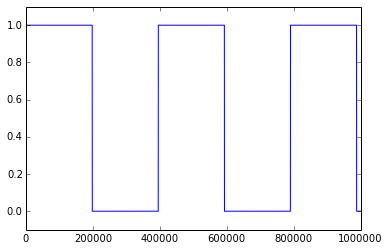

In [119]:
matched = find_tone(trunc_y0[delay:], f0, fc, fs)
print matched.size
print phase_diff.size
phase_offset = np.mean(phase_diff[matched])
print phase_offset # :/?

In [120]:
def sweep_angle(y0, y1, offset, step_size=1/80):
    phase_sweep = np.arange(-0.5,0.5+step_size,step_size) * 2 * pi
    all_summed = []
    for phase in phase_sweep:
        summed = y0 + np.exp(1j*(phase + offset)) * y1
        all_summed.append(np.abs(np.dot(summed, np.conj(summed))))
    
    ind = np.argmax(np.array(all_summed))
    
    x = []
    y = []
    for phase, energy in zip(phase_sweep, all_summed):
        x.append(energy*np.cos(phase/2 - pi/2))
        y.append(energy*np.sin(phase/2 - pi/2))
        
        #x.append(-energy*np.cos(phase/2 + pi/2))
        #y.append(-energy*np.sin(phase/2 + pi/2))
    
    plt.polar(np.concatenate((phase_sweep/2, phase_sweep/2 - pi)), all_summed*2)#, polar=True)
    #plt.polar(, all_summed)
    ax = plt.gca()
    ax.set_theta_zero_location('N')
    #ax.set_rscale('log')
    ax.set_rlim(np.max(np.log(all_summed))*1.25)

    
    print np.argmax(all_summed)
    print phase_sweep[ind] - offset

24
0.767335358977


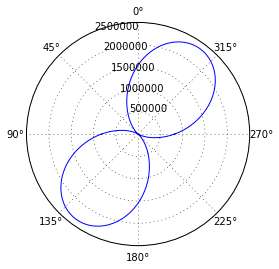

In [121]:
sweep_angle(trunc_y0, trunc_y1, phase_offset)